In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os
import h5py
import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

from torchvision import transforms
from torch.utils import data
from sklearn.model_selection import KFold

datadir = ""
training_set = datadir + 'DR12Q-63000.h5'


In [2]:
f = h5py.File(training_set, 'r') 
f.keys()

<KeysViewHDF5 ['FLUX', 'PLATE_F', 'PLATE_T', 'Z_DR12Q_VI', 'Z_PCA', 'Z_PIPE', 'Z_QN']>

In [3]:
X = f['FLUX'][()]  
Y = f['Z_DR12Q_VI'][()]
Z= f['Z_QN'][()]
W= f['Z_PIPE'][()]
S= f['Z_PCA'][()]



In [4]:
X.shape,Y.shape

((63100, 2000), (63100, 1))

In [5]:
#features = torch.Tensor(X).view(-1,4000)
#labels = torch.Tensor(Y).view(-1,1)

label_std = (Y.std()**1.0) 
label_mean = Y.mean() 
labels_norm = (Y - label_mean)/label_std

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X ,labels_norm, test_size= 0.1,random_state = 42 )
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X ,Z, test_size= 0.1,random_state = 42 )
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X ,W, test_size= 0.1,random_state = 42 )
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X ,S, test_size= 0.1,random_state = 42 )

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train ,Y_train, test_size= 0.24,random_state = 42 )

In [8]:
from skorch.helper import predefined_split
from skorch.dataset import Dataset

X_train=torch.Tensor(X_train).view(-1,2000)
Y_train=torch.Tensor(Y_train).view(-1,1)
X_test=torch.Tensor(X_test).view(-1,2000)
Y_test=torch.Tensor(Y_test).view(-1,1)

Y_test1=torch.Tensor(Y_test1).view(-1,1)
Y_test2=torch.Tensor(Y_test2).view(-1,1)
Y_test3=torch.Tensor(Y_test3).view(-1,1)

#Z_test=torch.Tensor(Z_test).view(-1,1)

X_valid=torch.Tensor(X_valid).view(-1,2000)
Y_valid=torch.Tensor(Y_valid).view(-1,1)


#Z_test=torch.Tensor(Z_test).view(-1,1)
valid_ds = Dataset(X_valid, Y_valid)




In [9]:
#dataset_train = TensorDataset(X_train, Y_train)
#dataset_test = TensorDataset(X_test, Y_test)
#dataset_QN = TensorDataset(X_test, Z_test)

In [10]:
#self.layer4 = nn.Sequential(
 #           nn.Conv1d(36, 20, 12),
 #           nn.ReLU(),
 #           nn.MaxPool1d(2, stride=2))

In [11]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 60, 200),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(60, 70,200),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv1d(70, 36, 32),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Sequential(
            nn.Linear(5724, 900),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(900, 100),
            nn.ReLU())
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [12]:
model= FNet()
print(model)

FNet(
  (layer1): Sequential(
    (0): Conv1d(1, 60, kernel_size=(200,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(60, 70, kernel_size=(200,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv1d(70, 36, kernel_size=(32,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Sequential(
    (0): Linear(in_features=5724, out_features=900, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=900, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [13]:
#torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1, verbose=False)

In [14]:
from skorch import NeuralNet
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import StepLR

#from skorch.dataset import CVSplit
net1 = NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =75,
               batch_size=100,
                optimizer=torch.optim.Adam,
                optimizer__lr =0.00014,#=0.00011,=0.000051,=0.000001,=0.0000001
                optimizer__weight_decay=1e-5,#0.00005,
                #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1),
                #optimizer__epsilon=1e-08,
                #optimizer__alpha=0.1,
                train_split=predefined_split(valid_ds),
                optimizer__betas=(0.9, 0.999),
               device ='cuda') 
net1.fit(X_train,Y_train)
net2 = NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =10,
               batch_size=100,
                optimizer=torch.optim.Adam,
                optimizer__lr =0.000014,#=0.00011,=0.000051,=0.000001,=0.0000001
                optimizer__weight_decay=1e-5,#0.00005,
                #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1),
                #optimizer__epsilon=1e-08,
                #optimizer__alpha=0.1,
                train_split=predefined_split(valid_ds),
                optimizer__betas=(0.9, 0.999),
               device ='cuda') 
net2.fit(X_train,Y_train)
net3 = NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =5,
               batch_size=100,
                optimizer=torch.optim.Adam,
                optimizer__lr =0.0000014,#=0.00011,=0.000051,=0.000001,=0.0000001
                optimizer__weight_decay=1e-5,#0.00005,
                #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1),
                #optimizer__epsilon=1e-08,
                #optimizer__alpha=0.1,
                train_split=predefined_split(valid_ds),
                optimizer__betas=(0.9, 0.999),
               device ='cuda') 
net3.fit(X_train,Y_train)
net = NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =3,
               batch_size=100,
                optimizer=torch.optim.Adam,
                optimizer__lr =0.00000014,#=0.00011,=0.000051,=0.000001,=0.0000001
                optimizer__weight_decay=1e-5,#0.00005,
                #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1),
                #optimizer__epsilon=1e-08,
                #optimizer__alpha=0.1,
                train_split=predefined_split(valid_ds),
                optimizer__betas=(0.9, 0.999),
               device ='cuda') 
net.fit(X_train,Y_train)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        0.1897        0.0567  117.1938
      2        0.0547        0.0322  119.1431
      3        0.0350        0.0231  119.6228
      4        0.0245        0.0189  119.6654
      5        0.0210        0.0186  119.6714
      6        0.0181        0.0189  119.6265
      7        0.0161        0.0153  119.6105
      8        0.0153        0.0142  119.5705
      9        0.0125        0.0132  119.5515
     10        0.0126        0.0116  119.4881
     11        0.0109        0.0137  119.5454
     12        0.0095        0.0118  119.4856
     13        0.0090        0.0117  119.4631
     14        0.0078        0.0121  119.4903
     15        0.0081        0.0102  119.4952
     16        0.0128        0.0120  119.4586
     17        0.0073        0.0111  119.4195
     18        0.0071        0.0102  119.4093
     19        0.0062        0.0105  119.3982
     20        0.0063        0.008

<class 'skorch.net.NeuralNet'>[initialized](
  module_=FNet(
    (layer1): Sequential(
      (0): Conv1d(1, 60, kernel_size=(200,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(60, 70, kernel_size=(200,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv1d(70, 36, kernel_size=(32,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (drop_out): Dropout(p=0.5, inplace=False)
    (fc1): Sequential(
      (0): Linear(in_features=5724, out_features=900, bias=True)
      (1): ReLU()
    )
    (fc2): Sequential(
      (0): Linear(in_features=900, out_features=100, bias=True)
      (1): ReLU()
    )
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  ),
)

In [15]:
#import skorch
#from skorch import NeuralNetRegressor

#from sklearn.model_selection import RandomizedSearchCV

#import torch.nn as nn
#import torch.optim as optim
#import torch.nn.functional as F
#lr = (10**np.random.uniform(-5,-2.5,1000)).tolist()
#params = {
 #   'optimizer__lr': lr,
  #  'max_epochs':[300,400,500],
   # 'module__num_units': [14,20,28,36,42],
    #'module__drop' : [0,.1,.2,.3,.4]
#}

#gs = RandomizedSearchCV(net,params,refit=True,cv=3,scoring='neg_mean_squared_error',n_iter=100)

In [16]:
#optimizer=torch.optim.Adam
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
#for epoch in range(2):
 #   scheduler.step()
  #  net.fit(X_train,Y_train)

In [17]:
#net.fit(X_train,Y_train)

In [18]:
Losses =net.history


In [19]:
valid_loss = net.history[:,'valid_loss']


In [20]:
 train_loss = net.history[:,'train_loss']

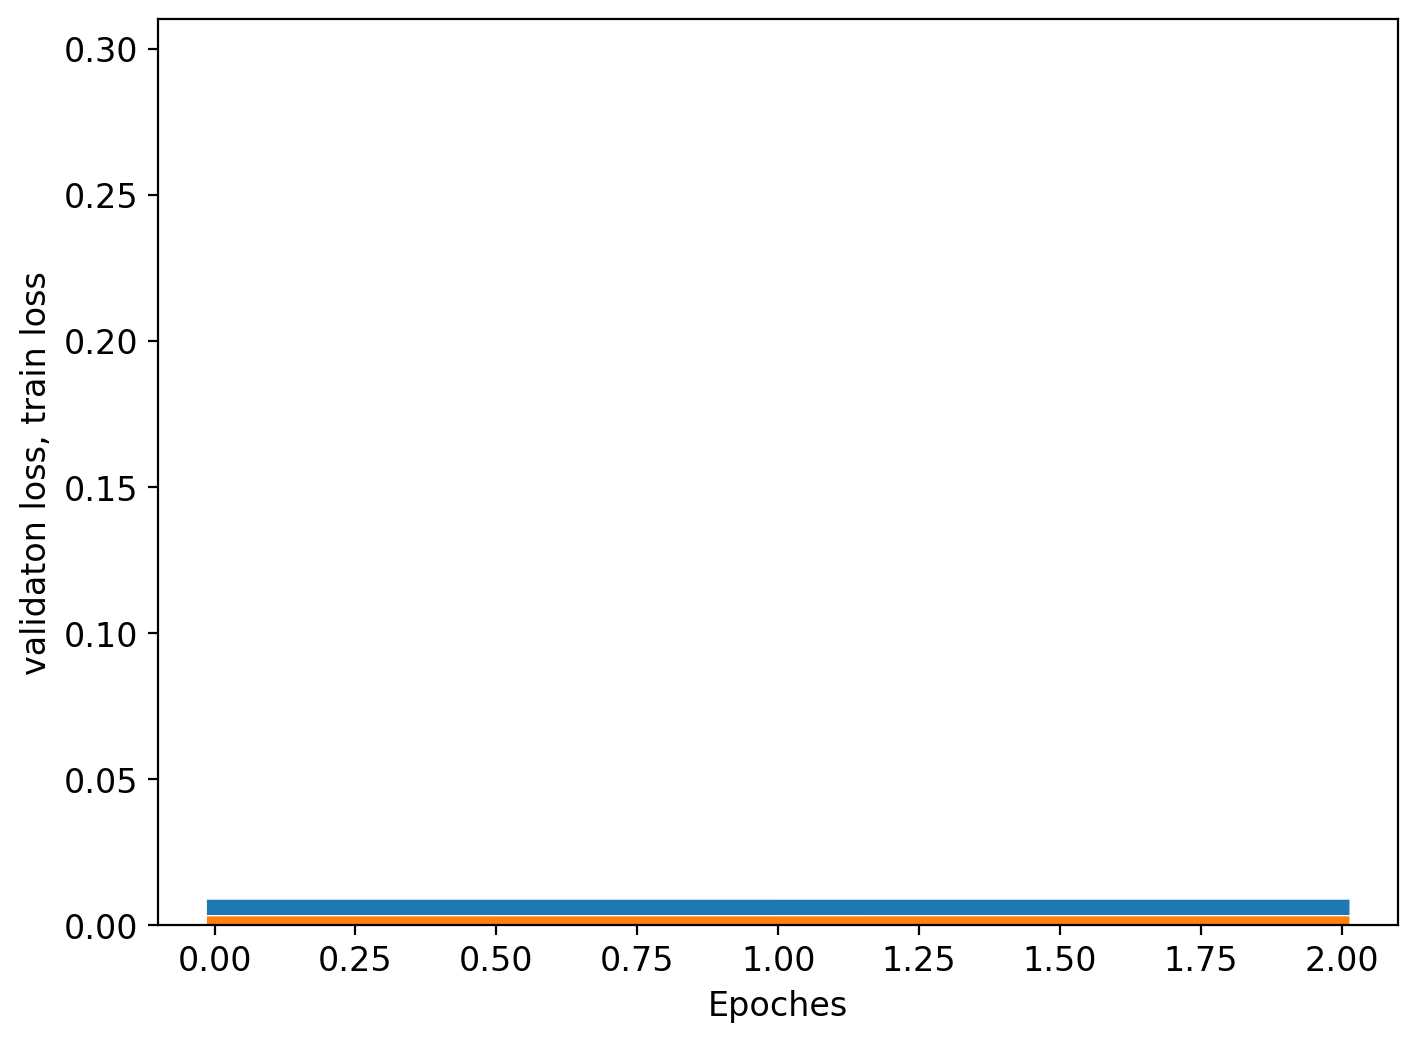

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.xlabel('Epoches')
plt.ylabel('validaton loss, train loss')
plt.plot(valid_loss,linewidth=5.5)
plt.plot(train_loss,linewidth=5.5)
#plt.xlim(0.1,7.1)
plt.ylim(0.0,0.31)
plt.show()

In [22]:
Y_pred = net.predict(X_test)
print(Y_pred)

[[ 0.19652833]
 [-0.88209236]
 [ 0.44115156]
 ...
 [ 0.1685026 ]
 [ 1.6632643 ]
 [ 2.43002   ]]


In [23]:
len(Y_test)

6310

In [24]:
Y_pred

array([[ 0.19652833],
       [-0.88209236],
       [ 0.44115156],
       ...,
       [ 0.1685026 ],
       [ 1.6632643 ],
       [ 2.43002   ]], dtype=float32)

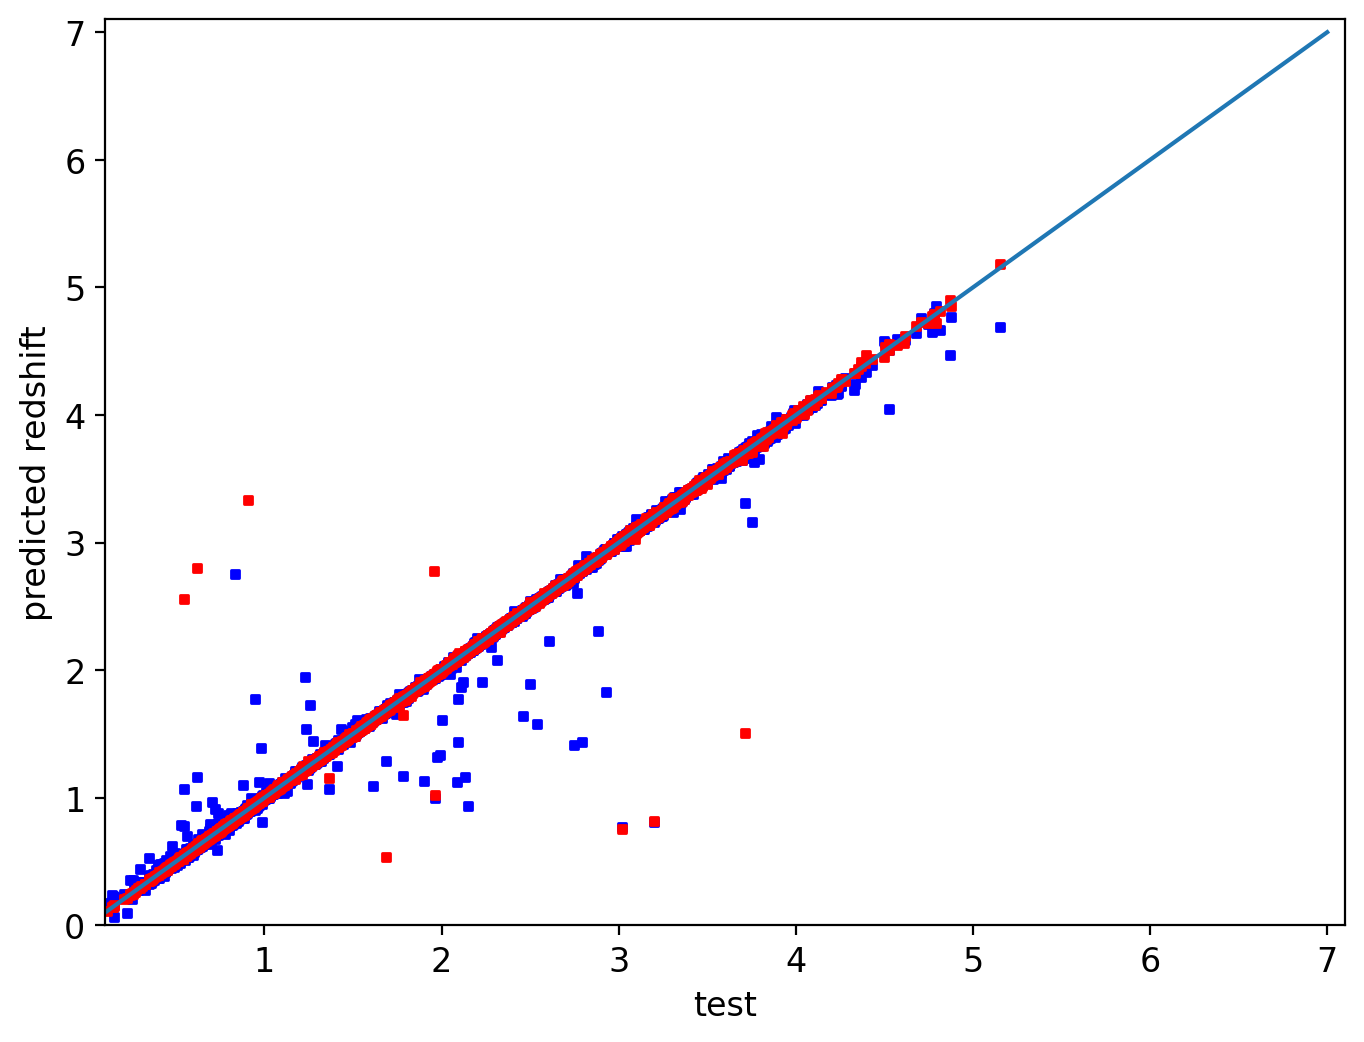

In [25]:
import matplotlib.pyplot as plt
labels_norm = (Y - label_mean)/label_std

Z = Y_pred*label_std+label_mean
y = Y_test*label_std+label_mean

x1=np.linspace(0,7,9)
y1=x1
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y, Z, s=10, c='b', marker="s")
ax1.scatter(y, Y_test1, s=10, c='r', marker="s")
plt.plot(x1,y1)
plt.xlabel('test')
plt.ylabel('predicted redshift')
plt.xlim(0.1,7.1)
plt.ylim(0.0,7.1)
plt.show()

In [26]:
REL=300000*(Z-y.numpy())/(1+y.numpy())
REL1=300000*(Y_test1.numpy()-y.numpy())/(1+y.numpy())
REL2=300000*(Y_test2.numpy()-y.numpy())/(1+y.numpy())
REL3=300000*(Y_test3.numpy()-y.numpy())/(1+y.numpy())
print(abs(REL).mean(),REL.mean())

1606.7958814564938 -3.9322942598466337


In [27]:
for i in range(len(REL1)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))

In [28]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((y.numpy()[i]>2.0)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines()))

3273


In [41]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

0.9771790808240888


In [30]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL1[i])<12000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

0.998256735340729


In [31]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL2[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

0.9868462757527734


In [32]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL3[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

0.9992076069730587


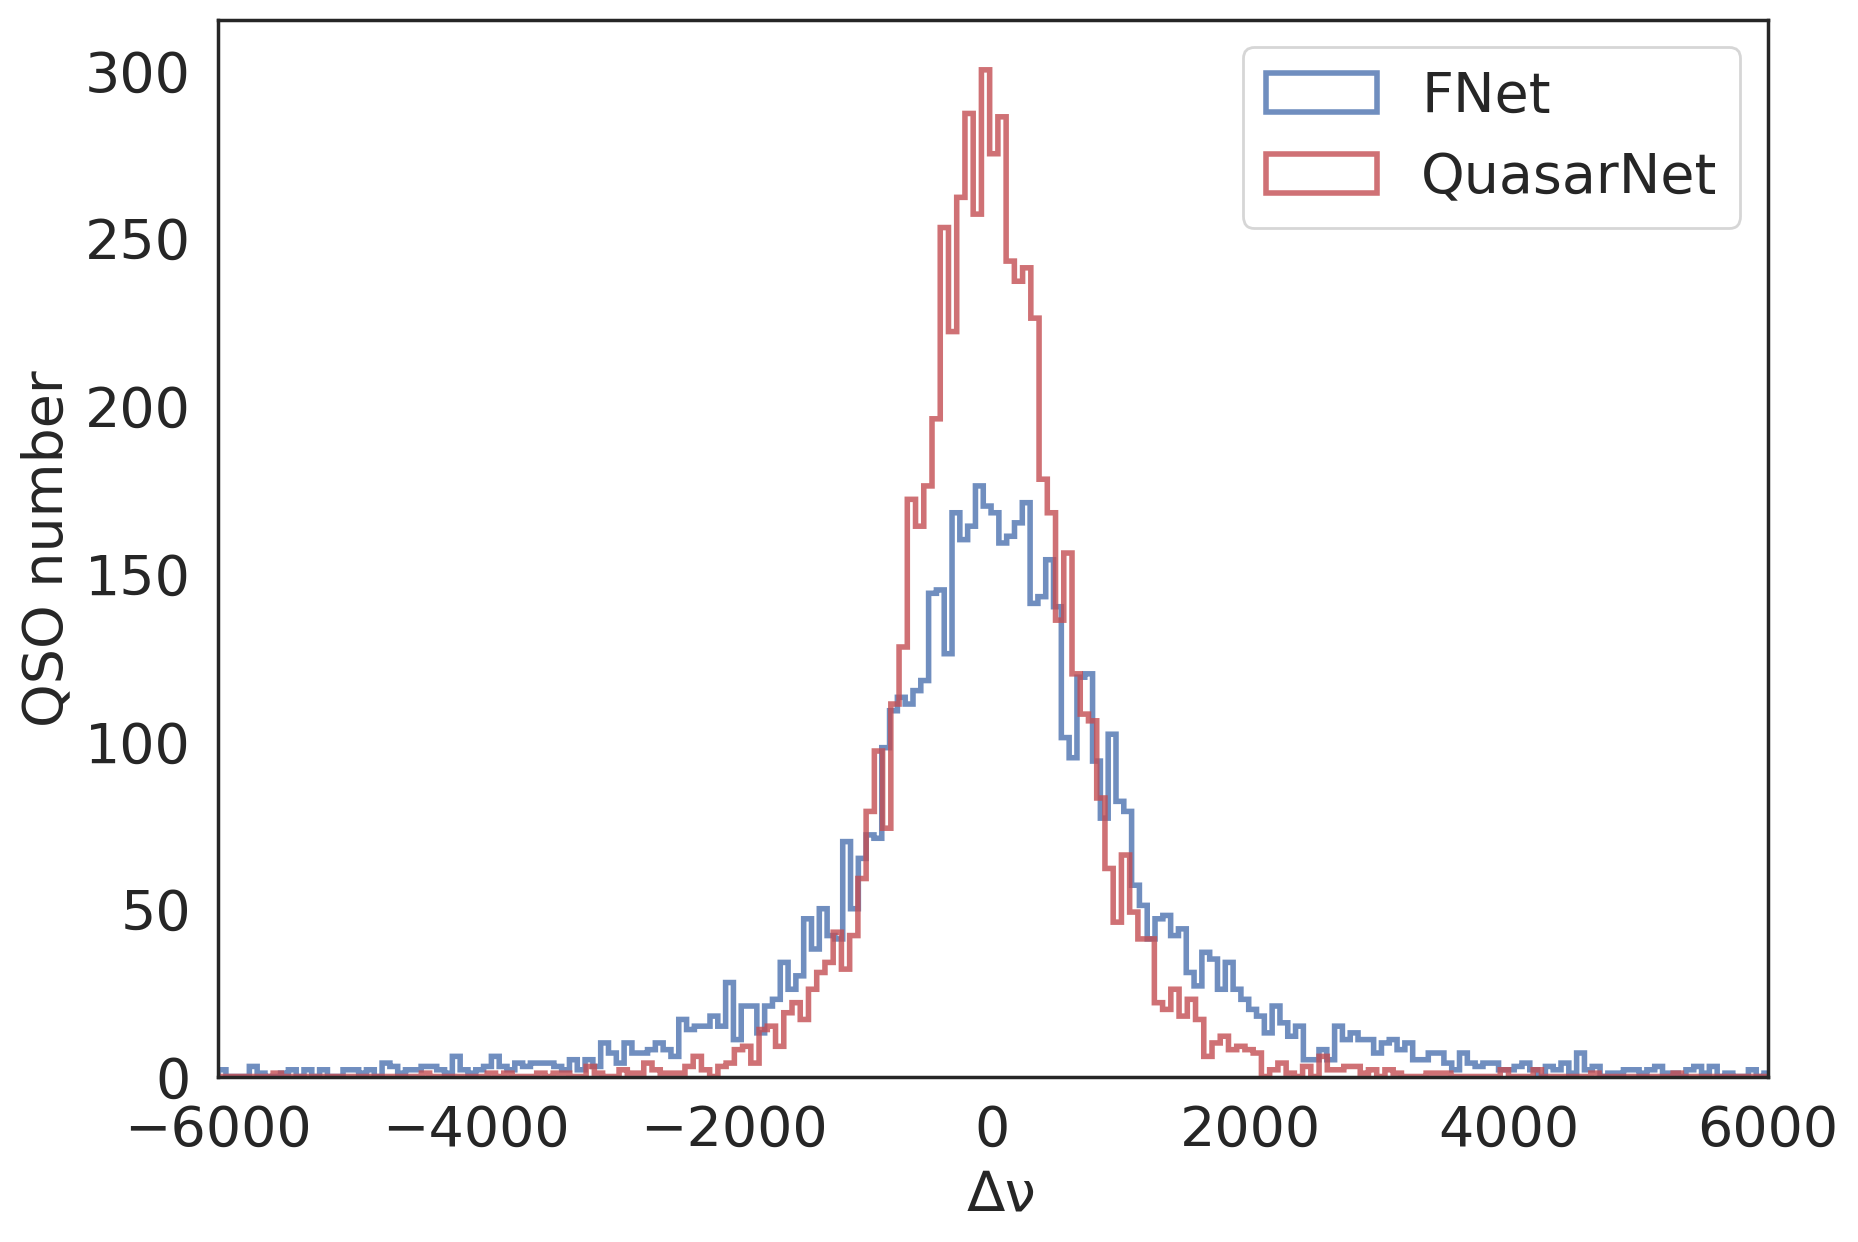

In [33]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
#pyplot.yscale('log')
data = REL
plt.figure(figsize=(10,7))

sns.set_style('white')

plt.hist(data, bins=8000,histtype='step',alpha=0.8,edgecolor='b',linewidth=2,label='FNet')
plt.hist(REL1, bins=9000,histtype='step',alpha=0.8,edgecolor='r',linewidth=2,label='QuasarNet')
#plt.hist(REL2, bins=6000,histtype='step',alpha=0.3,edgecolor='g',linewidth=2,label='ZPIPW')
#plt.hist(REL3, bins=9000,histtype='step',alpha=0.3,edgecolor='black',linewidth=2,label='PCA')

plt.ylabel('QSO number', fontsize=20)
plt.yticks(fontsize=20) 

plt.xlabel(' ∆ν', fontsize=20)
plt.xticks(fontsize=20) 


plt.xlim(-6000,6000)
plt.legend(loc='best', fontsize=20) 
#plt.ylim(0,7)
plt.savefig('FNet.pdf')
plt.show() 


In [34]:
#file = open('Rahim1.txt', "r+")
#file.truncate()
#for i in range(len(REL)):
 #   if ((abs(REL[i])>6000)):
  #      print(REL[i], file=open("Rahim1.txt", "a"))
#with open("Rahim1.txt","r") as f:
 #   print(1-len(f.readlines())/len(REL))

In [35]:
#from skorch import NeuralNet
#from skorch.callbacks import LRScheduler
#from torch.optim.lr_scheduler import CyclicLR

#def make_lookahead(parameters, optimizer_cls, k, alpha, **kwargs):
 #   optimizer = optimizer_cls(parameters, **kwargs)
  #  return Lookahead(optimizer=optimizer, k=k, alpha=alpha)


#net = NeuralNet(model,
 #              criterion =nn.MSELoss,
  #             max_epochs =3,
   #            batch_size=100,
    #    optimizer=make_lookahead,
     #   optimizer__optimizer_cls=torch.optim.Adam,
      #  optimizer__weight_decay=1e-2,
       # optimizer__k=5,
        #optimizer__alpha=0.5,
        #optimizer__betas=(0.9, 0.99),
        #lr=0.00000104)

In [36]:
#from skorch import NeuralNet
#from skorch.dataset import CVSplit
#net = NeuralNet(model,
 #              criterion =nn.MSELoss,
  #             max_epochs =1,
   #            batch_size=160,
    #            optimizer=torch.optim.Adam,
     #           lr =0.000000090,
      #         device ='cuda') 
#net.fit(X_train,Y_train)

In [37]:
#from skorch import NeuralNet
#from skorch.dataset import CVSplit
#net = NeuralNet(model,
 #              criterion =nn.MSELoss,
  #             max_epochs =20,
   #            batch_size=180,
    #            optimizer=torch.optim.Adam,
     #           lr =0.000000240,
      #         device ='cuda') 
#net.fit(X_train,Y_train)

In [38]:
#from skorch import NeuralNet
#from skorch.callbacks import LRScheduler
#from torch.optim.lr_scheduler import CyclicLR

#from skorch.dataset import CVSplit
#net = NeuralNet(model,
 #              criterion =nn.MSELoss,
  #             max_epochs =100,
   #            batch_size=140,
    #            optimizer=torch.optim.Adagrad,#torch.optim.Adam,
     #           lr =0.00024,
                #optimizer__betas=(0.9, 0.999),
      #          optimizer__lr_decay=0.00001,
       #         #optimizer__weight_decay=0.001,
        #       device ='cuda') 

In [39]:
#class RNet(nn.Module): #200-200-32
    
 #   def __init__(self):
  #      super(RNet, self).__init__()
   #     self.C1 = nn.Conv1d(1, 60, 200)
    #    self.S2 = nn.MaxPool1d(2, stride=2)
     #   self.C3 = nn.Conv1d(60, 40,200)
      #  self.S4 = nn.MaxPool1d(2, stride=2)
       # self.C5 = nn.Conv1d(40, 36, 32)
  #      self.S6 = nn.MaxPool1d(2, stride=2)
   #     self.D7 = nn.Dropout()
    #    self.F8 = nn.Linear(5724, 900)
     #   self.F9= nn.Linear(900, 100)
      #  self.Out= nn.Linear(100, 1)
        
   # def forward(self, x):
    #    x = x.unsqueeze(1)
     #   x = F.relu(self.C1(x))
      #  x = self.S2(x)
       # x = F.relu(self.C3(x))
#        x = self.S4(x)
 #       x = F.relu(self.C5(x))
  #      x = self.S6(x)
   #     x = self.D7(x)
#        x = x.view(x.size(0),-1)
 #       x = F.relu(self.F8(x))
  #      x = F.relu(self.F9(x))
   #     x = self.Out(x)
    #    return x
    

NameError: name 'datafit' is not defined

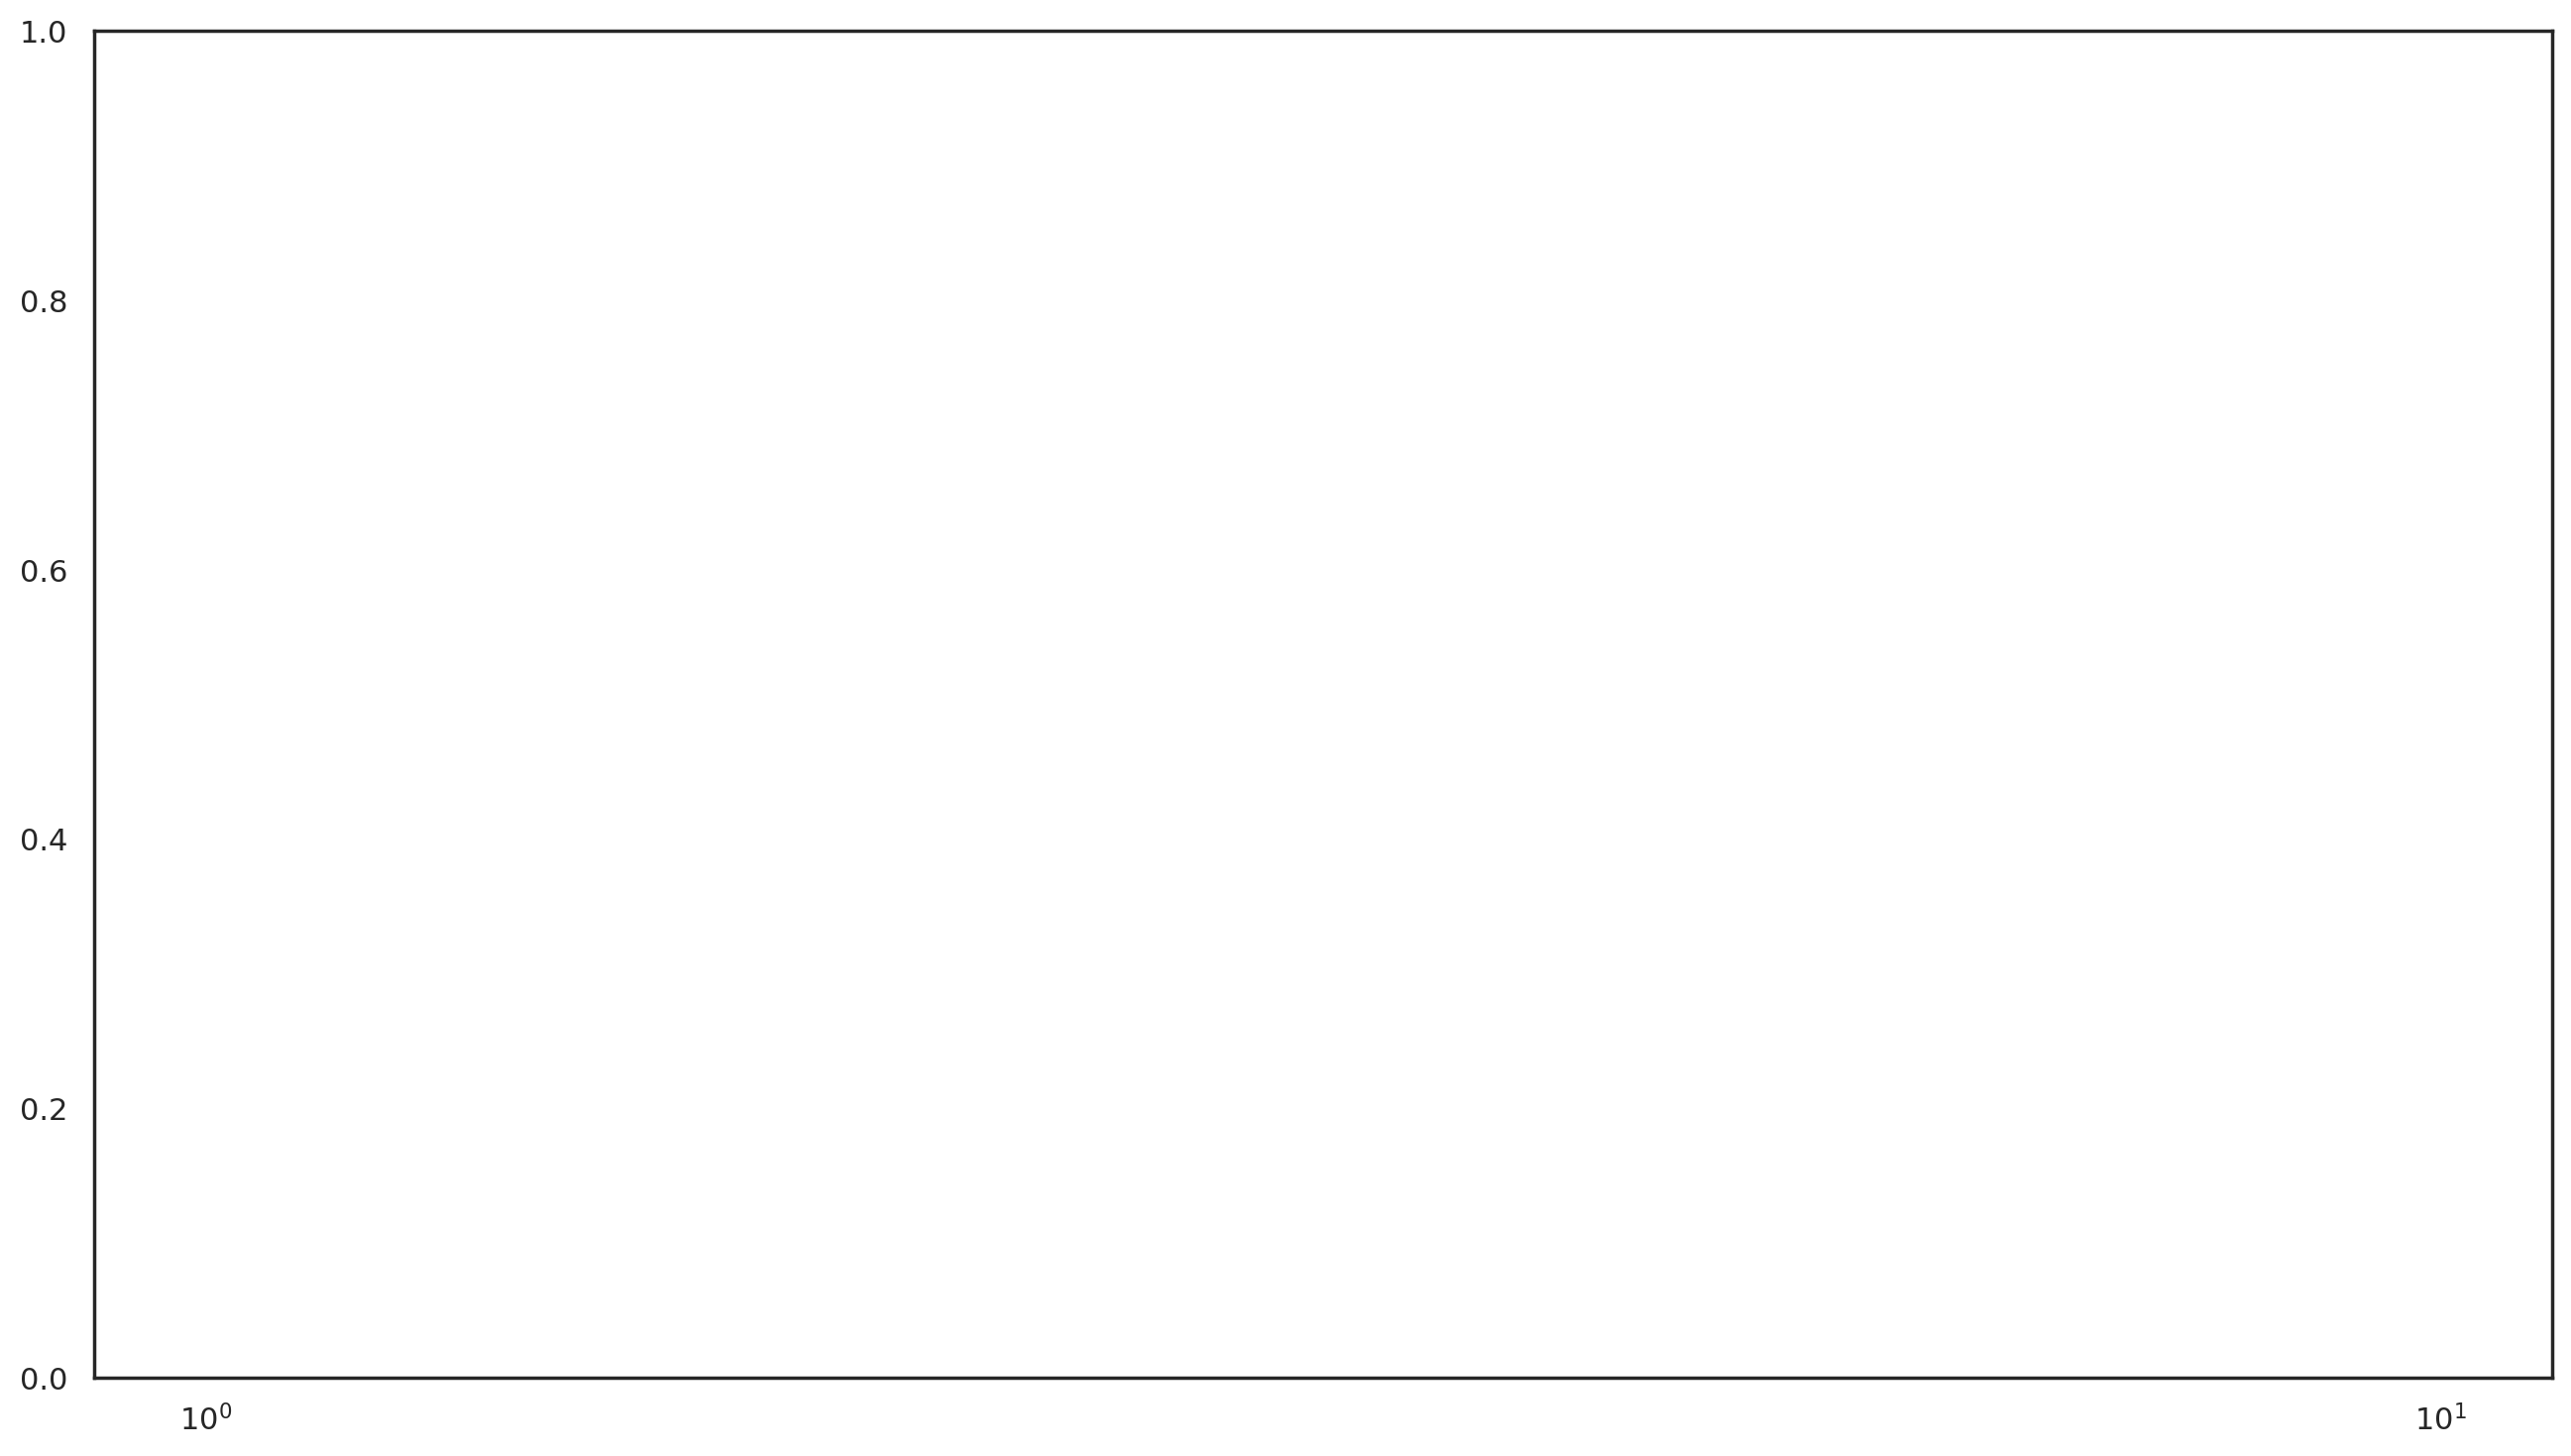

In [40]:
plt.figure(figsize=(16,9))

#pyplot.yscale('log') 
pyplot.xscale('log')


plt.errorbar(datafit['1'],datafit['2'], 0,0, capsize=0, markersize=6, fmt='o-',label='Train', color='blue',elinewidth=3.0, alpha=0.8)
plt.errorbar(datafit['1'],datafit['3'], 0,0, capsize=0, markersize=6, fmt='o-',label='Valid', color='red',elinewidth=3.0, alpha=0.8)




    

plt.xlabel('Epoches', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

plt.xlim(0.0, 100)
plt.ylim(0, 0.41)
plt.legend(loc='best', fontsize=18)

plt.savefig('Los.pdf')
plt.show()